--- 

## Exercise 5 : ARIMAX versur ARDL models

### Imports

In [123]:
import polars as pl 
from datetime import date 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
# import pmdarima as pm
from scipy.interpolate import CubicSpline
from statsmodels.tsa.ardl import ARDL


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd

In [2]:
# function to evaluate an ARIMA based on AIC
def evaluate_arima_model(time_series, arima_order):
    try:
        model = ARIMA(time_series, order=arima_order)
        model_fit = model.fit()
        return arima_order, model_fit.aic
    except Exception as e:
        print(e)
        return arima_order, None
    
# function to plot acf/pacf
def plot_acf_pacf(time_series, lags=20):
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot ACF
    plot_acf(time_series, lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(time_series, lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()


### Preprocessing 

We start by importing the data and cleaning it

In [3]:
dep_var = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        read_options={'skip_rows':10}
    )
    .select(
        pl.col("^.*Graph.*$").alias("date"), 
        pl.col("^.*UNNAMED.*$").alias("corbl")
    )
)

We plot the data to get a sense of potential seasonality/ non stationarity, etc

we find no significant pattern in the data

<Axes: xlabel='date'>

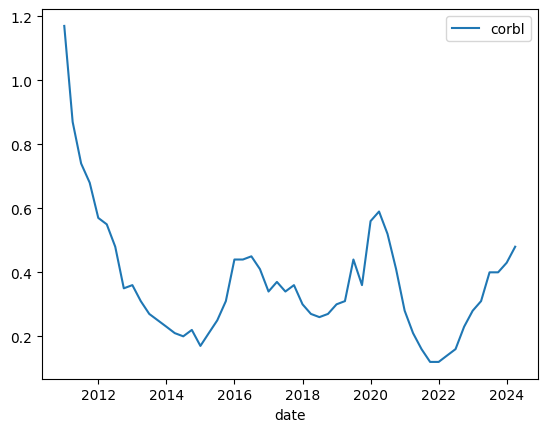

In [4]:
sns.lineplot(dep_var.to_pandas().set_index("date"))

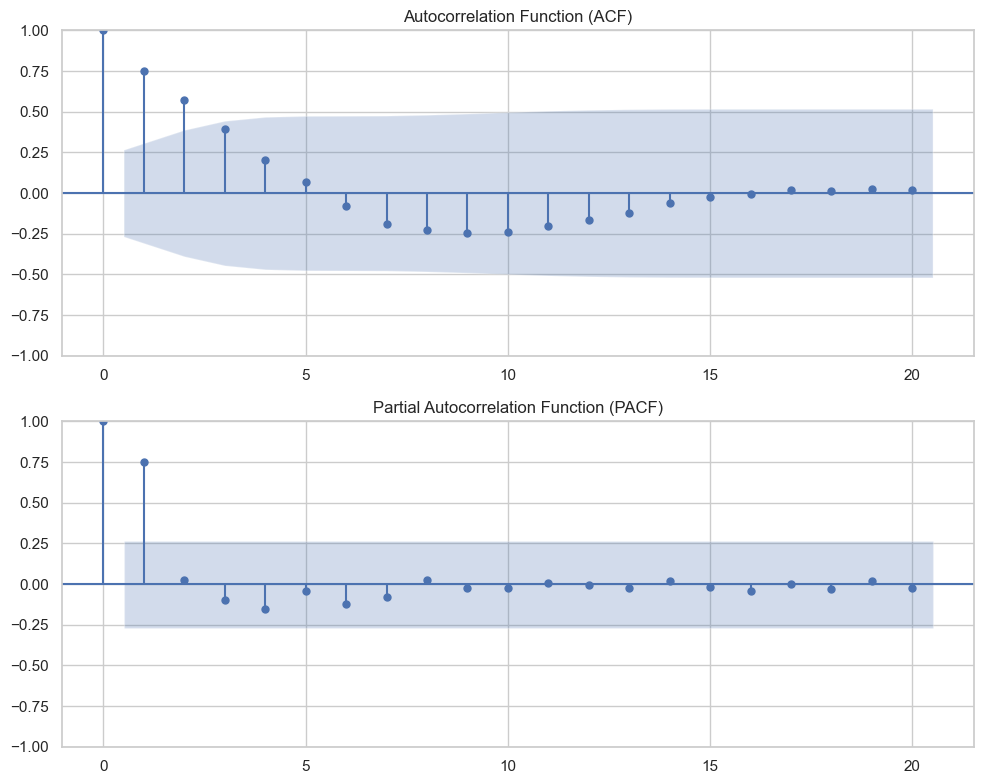

In [5]:
plot_acf_pacf(dep_var.select('corbl'))

We then split the data into train/test

In [6]:
in_sample = dep_var.filter(pl.col('date').lt(date(2023,1,1))) #stricly inferior
out_sample = dep_var.filter(pl.col('date').ge(date(2023,1,1)))

Then, we can fit the three different models in order to find the best one

We start with the ARIMA 

### ARIMA

In [7]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(in_sample.select("corbl").to_pandas()['corbl'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:-14.449043756492827
ARIMA(0, 0, 1) - AIC:-52.25780327659411
ARIMA(0, 0, 2) - AIC:-67.56891733223856
ARIMA(0, 0, 3) - AIC:-86.62591946537616
ARIMA(0, 0, 4) - AIC:-89.67342659832342
ARIMA(0, 1, 0) - AIC:-101.51000035129377
ARIMA(0, 1, 1) - AIC:-103.33153340945692
ARIMA(0, 1, 2) - AIC:-110.19446149841687
ARIMA(0, 1, 3) - AIC:-111.29712025084842
Best ARIMA(0, 1, 3) - AIC:-111.29712025084842


We then fit the ARIMA(0,1,3)

In [ ]:
model = ARIMA(in_sample.select("corbl").to_pandas()['corbl'], order=(0,1,3))
model_fit = model.fit()
in_sample_preds = model_fit.predict()
out_sample_preds = model_fit.forecast(6)

In [26]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  corbl   No. Observations:                   48
Model:                 ARIMA(0, 1, 3)   Log Likelihood                  59.649
Date:                Sun, 29 Dec 2024   AIC                           -111.297
Time:                        16:44:07   BIC                           -103.897
Sample:                             0   HQIC                          -108.512
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3778      0.123      3.070      0.002       0.137       0.619
ma.L2          0.6361      0.153      4.157      0.000       0.336       0.936
ma.L3          0.3517      0.159      2.209      0.0

In [16]:
predicted = pl.Series(in_sample_preds).append(pl.Series(out_sample_preds))

We then plot the results of the prediction vs the actual data

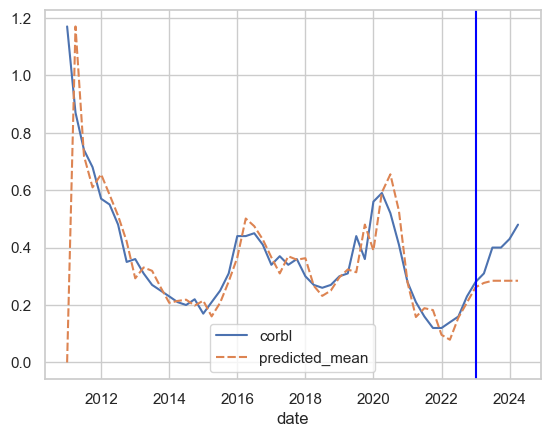

In [25]:
sns.lineplot(dep_var.with_columns(predicted).to_pandas().set_index('date'))
plt.axvline(date(2023,1,1), 0,1.2, color = 'blue')


We can see that there is a pretty large difference between the two

For the next models, we will need to import the explanatory variables

In [31]:
gdp = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        sheet_id=3
    )
)

cpi = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        sheet_id=4
    )
)

unrate = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        sheet_id=5
    )
)

ieabc = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        sheet_id=6
    )
)

We can also plot them (we plot the GDP separately because the scales are too different)

<Axes: xlabel='Date'>

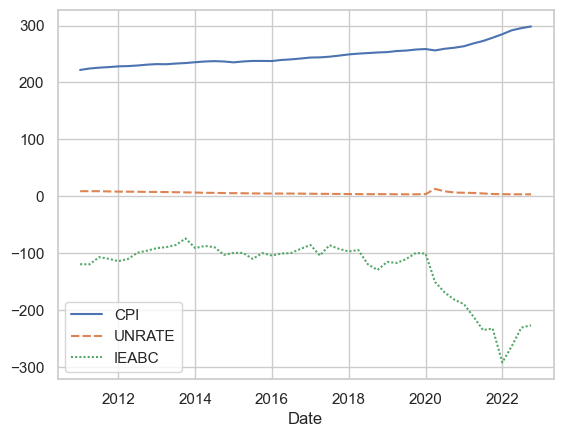

In [37]:
sns.lineplot(cpi.join(unrate, on = "Date").join(ieabc, on ="Date").to_pandas().set_index("Date"))

<Axes: xlabel='Date'>

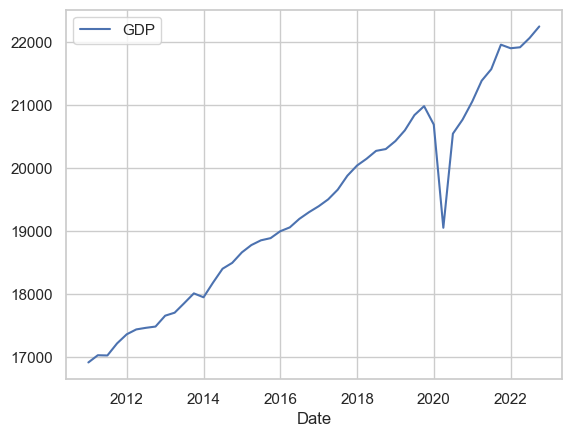

In [38]:
sns.lineplot(gdp.to_pandas().set_index("Date"))

We immediately see a clear trend (non stationarity) in the GDP

We start by fitting the ARIMAX model, which is essentially the same thing as the ARIMA excep we add the four variables.

In [41]:
exogs = cpi.join(unrate, on = "Date").join(ieabc, on ="Date").join(gdp, on = "Date")
exogs.head()

Date,CPI,UNRATE,IEABC,GDP
date,f64,f64,f64,f64
2011-01-01,222.043667,9.033333,-119.236,16920.632
2011-04-01,224.568333,9.066667,-119.435,17035.114
2011-07-01,226.032667,9.0,-106.86,17031.313
2011-10-01,227.047333,8.633333,-109.771,17222.583
2012-01-01,228.326,8.266667,-113.912,17367.01


In [50]:
formatted_exog_in_sample = exogs.to_pandas()[['CPI', 'UNRATE', 'IEABC', 'GDP']]

In [51]:
model = ARIMA(in_sample.select("corbl").to_pandas()['corbl'], order=(0,1,3), exog=formatted_exog_in_sample)
model_fit = model.fit()
in_sample_preds = model_fit.predict()
# out_sample_preds = model_fit.forecast(6, exog =formatted_exog_out_sample )

before applying the cubic spline, we can look at how the model fits in sample

In [52]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  corbl   No. Observations:                   48
Model:                 ARIMA(0, 1, 3)   Log Likelihood                  63.590
Date:                Sun, 29 Dec 2024   AIC                           -111.179
Time:                        17:11:34   BIC                            -96.378
Sample:                             0   HQIC                          -105.609
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI           -0.0069      0.006     -1.232      0.218      -0.018       0.004
UNRATE        -0.0068      0.010     -0.687      0.492      -0.026       0.013
IEABC         -0.0004      0.001     -0.653      0.5

In [ ]:
# we remove the first value because otherwise we have less visibility on the graph
dep_var.filter(pl.col('date').lt(date(2023,1,1))).filter(pl.col('date').gt(date(2011,1,1))).with_columns(pl.Series(in_sample_preds[1:])).head()

date,corbl,predicted_mean
date,f64,f64
2011-04-01,0.87,1.143437
2011-07-01,0.74,0.831228
2011-10-01,0.68,0.593176
2012-01-01,0.57,0.631463
2012-04-01,0.55,0.605597


<Axes: xlabel='date'>

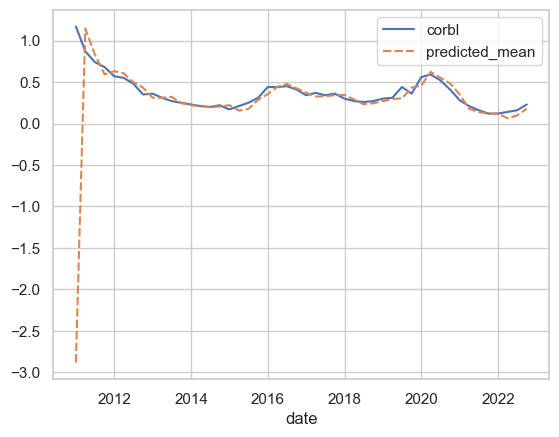

In [59]:
sns.lineplot(dep_var.filter(pl.col('date').lt(date(2023,1,1))).with_columns(pl.Series(in_sample_preds)).to_pandas().set_index('date'))
# plt.axvline(date(2023,1,1), 0,1.2, color = 'blue')

<Axes: xlabel='date'>

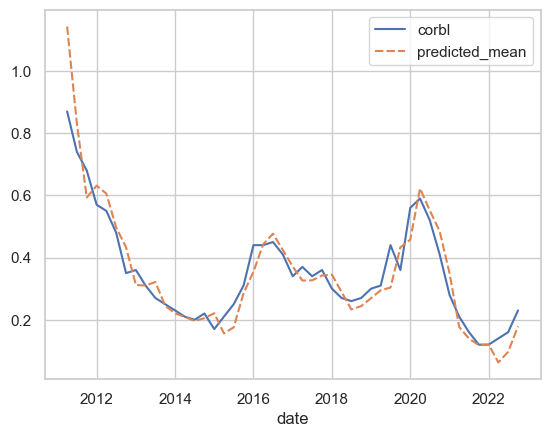

In [64]:
sns.lineplot(dep_var.filter(pl.col('date').lt(date(2023,1,1))).filter(pl.col('date').gt(date(2011,1,1))).with_columns(pl.Series(in_sample_preds[1:])).to_pandas().set_index('date'))


We now import the variables needed to predict the out of sample forecasts

In [82]:
estimates = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        sheet_id=2,
        read_options={'skip_rows':7}
    )
    .select(pl.col("^.*International.*$").alias('Date'), pl.col("^.*__1.*$").alias('GDP'), pl.col("^.*__2.*$").alias('CPI'), pl.col("^.*3.*$").alias('UNRATE'), pl.col("^.*3.*$").alias('IEABC'))
)

In [83]:
estimates.head()

Date,GDP,CPI,UNRATE,IEABC
i64,f64,f64,f64,f64
2011,17222.583,224.923,8.933,8.933
2012,17615.391444,229.586,8.075,8.075
2013,17939.84179,232.952,7.358,7.358
2014,18350.234224,236.715,6.158,6.158
2015,18846.893872,237.002,5.275,5.275


Then, we apply a cubic spline to 2023

In [91]:
pd_estimates = estimates.to_pandas()

In [92]:
import pandas as pd
pd_estimates['Date'] = pd.to_datetime(pd_estimates['Date'], format='%Y')

In [94]:
pd_estimates.set_index("Date", inplace=True)

In [98]:
def get_cubic_spline(var: str = 'GDP'):
    years = pd_estimates.index.year
    values = pd_estimates[var]

    # Create the cubic spline interpolation
    cs = CubicSpline(years, values, bc_type='natural')

    # Generate quarterly dates
    start_year = years.min()
    end_year = years.max()
    quarterly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='Q')

    # Interpolate the values at quarterly intervals
    quarterly_values = cs(quarterly_dates.year + (quarterly_dates.quarter - 1) / 4.0)

    return quarterly_values

In [99]:
q_values_gdp = get_cubic_spline('GDP')
q_values_cpi = get_cubic_spline('CPI')
q_values_unrate = get_cubic_spline('UNRATE')
q_values_ieabc = get_cubic_spline('IEABC')

C:\Users\faune\AppData\Local\Temp\ipykernel_28572\1757722863.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='Q')
C:\Users\faune\AppData\Local\Temp\ipykernel_28572\1757722863.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='Q')
C:\Users\faune\AppData\Local\Temp\ipykernel_28572\1757722863.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='Q')
C:\Users\faune\AppData\Local\Temp\ipykernel_28572\1757722863.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range(star

In [101]:
quarterly_dates = pl.date_range(start=date(2011,1,1), end=date(2027,12,31), interval='1q', eager=True)

In [109]:
q_estimates = (
    pl.DataFrame(quarterly_dates)
    .with_columns(pl.Series(name = 'CPI', values = q_values_cpi))
    .with_columns(pl.Series(name = 'GDP', values = q_values_gdp))
    .with_columns(pl.Series(name = 'UNRATE', values = q_values_unrate))
    .with_columns(pl.Series(name = 'IEABC', values = q_values_ieabc))
    .with_columns(pl.col('literal').alias('date'))
    .drop('literal')
)

In [115]:
q_estimates

CPI,GDP,UNRATE,IEABC,date
f64,f64,f64,f64,date
224.923,17222.583,8.933,8.933,2011-01-01
226.195243,17325.880807,8.700749,8.700749,2011-04-01
227.424889,17427.140335,8.475599,8.475599,2011-07-01
228.569341,17524.323307,8.264649,8.264649,2011-10-01
229.586,17615.391444,8.075,8.075,2012-01-01
…,…,…,…,…
327.445604,23034.433404,4.739415,4.739415,2026-10-01
329.105,23136.967902,4.703,4.703,2027-01-01
330.764396,23239.5024,4.666585,4.666585,2027-04-01


We then get the estimates for 2023

In [116]:
q_estimates_2023 = q_estimates.filter(pl.col('date').ge(date(2022,1,1))).filter(pl.col('date').le(date(2023,4,1)))

In [118]:
q_estimates_2023

CPI,GDP,UNRATE,IEABC,date
f64,f64,f64,f64,date
292.784,21399.963436,3.67,3.67,2022-01-01
296.526574,21434.667043,3.754183,3.754183,2022-04-01
299.253567,21486.55583,3.964555,3.964555,2022-07-01
301.311776,21548.397021,4.249398,4.249398,2022-10-01
303.048,21612.95784,4.557,4.557,2023-01-01
304.748148,21674.880237,4.842509,4.842509,2023-04-01


We then go back to our forecasts

In [119]:
formatted_exog_out_sample = q_estimates_2023.to_pandas()[['CPI', 'UNRATE', 'IEABC', 'GDP']]
out_sample_preds = model_fit.forecast(6, exog =formatted_exog_out_sample )

In [120]:
out_sample_preds

48    0.293007
49    0.296437
50    0.271632
51    0.250535
52    0.231278
53    0.212636
Name: predicted_mean, dtype: float64

In [121]:
predicted = pl.Series(in_sample_preds).append(pl.Series(out_sample_preds))

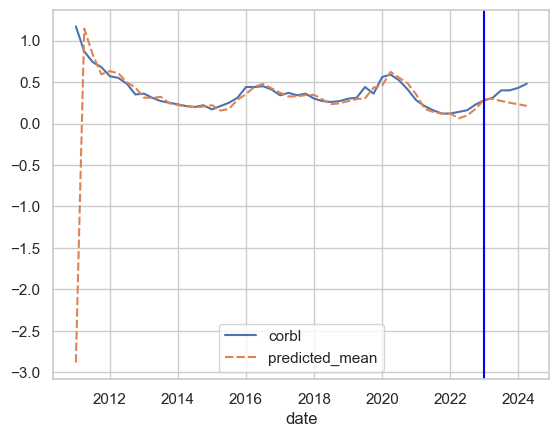

In [122]:
sns.lineplot(dep_var.with_columns(predicted).to_pandas().set_index('date'))
plt.axvline(date(2023,1,1), 0,1.2, color = 'blue')


We see that the difference is less drastic here than in the pure ARIMA model

We can now move on to the ARDL model

### ARDL

We find the best arima for each exog variable

GDP

In [129]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(exogs.select("GDP").to_pandas()['GDP'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:845.5262171066433
ARIMA(0, 0, 1) - AIC:799.6208206680601
ARIMA(0, 0, 2) - AIC:775.5567410997685
ARIMA(0, 0, 3) - AIC:758.2553673543168
ARIMA(0, 0, 4) - AIC:753.9430526363051
ARIMA(0, 1, 0) - AIC:688.8257087142799
ARIMA(1, 1, 2) - AIC:688.4250951484953
Best ARIMA(1, 1, 2) - AIC:688.4250951484953


In [130]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(exogs.select("CPI").to_pandas()['CPI'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:421.37336258744836
ARIMA(0, 0, 1) - AIC:365.8792392070848
ARIMA(0, 0, 2) - AIC:322.71192037476953
ARIMA(0, 0, 3) - AIC:283.70807152828144
ARIMA(0, 0, 4) - AIC:267.7821634559782
ARIMA(0, 1, 0) - AIC:217.421976596953
ARIMA(0, 1, 1) - AIC:191.37497850101863
ARIMA(0, 1, 2) - AIC:187.02351453976655
ARIMA(0, 1, 3) - AIC:171.03706448664667
ARIMA(0, 2, 0) - AIC:166.16210840265265
ARIMA(0, 2, 1) - AIC:160.38434249515973
ARIMA(1, 2, 2) - AIC:159.326973113878
Best ARIMA(1, 2, 2) - AIC:159.326973113878


In [131]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(exogs.select("UNRATE").to_pandas()['UNRATE'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:209.89174085990487
ARIMA(0, 0, 1) - AIC:190.10405268910418
ARIMA(0, 0, 2) - AIC:185.77624532186726
ARIMA(0, 0, 3) - AIC:185.00967571311986
ARIMA(0, 1, 0) - AIC:175.13650756842705
ARIMA(0, 1, 1) - AIC:173.61301802885194
Best ARIMA(0, 1, 1) - AIC:173.61301802885194


In [132]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(exogs.select("IEABC").to_pandas()['IEABC'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:521.6074009029709
ARIMA(0, 0, 1) - AIC:470.3249065397122
ARIMA(0, 0, 2) - AIC:457.3262295592392
ARIMA(0, 0, 3) - AIC:434.3523568431842
ARIMA(0, 0, 4) - AIC:425.00979863457474
ARIMA(0, 1, 0) - AIC:398.6848361638929
ARIMA(0, 1, 4) - AIC:398.52160547124396
ARIMA(0, 2, 1) - AIC:395.8809758438864
Best ARIMA(0, 2, 1) - AIC:395.8809758438864


In [133]:
formatted_exog_in_sample.head()

,CPI,UNRATE,IEABC,GDP
0,222.043667,9.033333,-119.236,16920.632
1,224.568333,9.066667,-119.435,17035.114
2,226.032667,9.000000,-106.860,17031.313
3,227.047333,8.633333,-109.771,17222.583
4,228.326000,8.266667,-113.912,17367.010


In [134]:
# we use lags of 3 as in the first ARIMA
ardl_model = ARDL(
    in_sample.select("corbl").to_pandas()['corbl'],
    3, 
    formatted_exog_in_sample, 
    {
        "CPI":2,
        "UNRATE":1,
        "IEABC":1,
        "GDP":2
    })
results = ardl_model.fit()

print(results.summary())


                               ARDL Model Results                              
Dep. Variable:                   corbl   No. Observations:                   48
Model:             ARDL(3, 2, 1, 1, 2)   Log Likelihood                  78.350
Method:                Conditional MLE   S.D. of innovations              0.042
Date:                 Sun, 29 Dec 2024   AIC                           -126.700
Time:                         20:50:25   BIC                            -99.600
Sample:                              3   HQIC                          -116.598
                                    48                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2790      0.383      0.727      0.472      -0.503       1.061
corbl.L1       0.6918      0.177      3.903      0.000       0.330       1.053
corbl.L2       0.5169      0.246      2.101 

In [135]:
in_sample_preds = results.predict()
out_sample_preds = results.forecast(6, exog =formatted_exog_out_sample )

In [136]:
predicted = pl.Series(in_sample_preds).append(pl.Series(out_sample_preds))

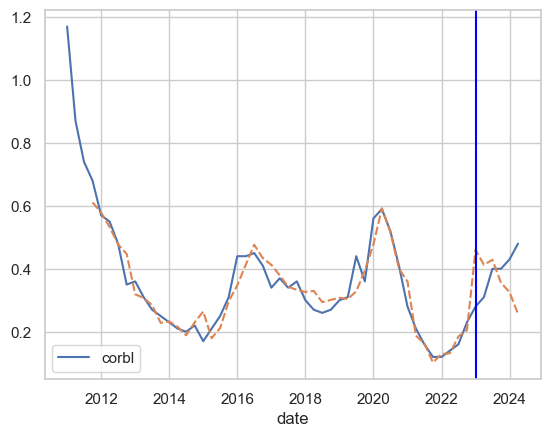

In [137]:
sns.lineplot(dep_var.with_columns(predicted).to_pandas().set_index('date'))
plt.axvline(date(2023,1,1), 0,1.2, color = 'blue')


### Conclusion

We can see that the ARDL model does not necessarilly improve the forecast compared to the simple ARIMAX model

The best model therefore seems to be the ARIMAX